This script generates the plots to compare SCITE-RNA, DENDRO and SClineager on simulated datasets with a variable number of ground truth clones. Additionally, it plots a comparison of the runtimes.

In [22]:
import numpy as np
import re
import warnings
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import dendropy
from dendropy.calculate import treecompare
import pandas as pd
from matplotlib.font_manager import FontProperties
import os
from collections import Counter
import seaborn as sns
import json

from src_python.mutation_filter import MutationFilter
from src_python.cell_tree import CellTree
from src_python.mutation_tree import MutationTree
from src_python.utils import load_config_and_set_random_seed, path_len_dist, create_mutation_matrix, \
    create_genotype_matrix, mut_count_distance
from dendropy import Tree, TreeList, TaxonNamespace

In [23]:
path = "../data/simulated_data"

n_cells = [50]
n_mut = [100]
n_tests = 100
clones = [5, ""]
stratified = ""  # "_stratified" # stratified means all clones are about equally large

use_summary_statistics = False #True # Uses the summary files saved in the data/ directory. If raw output files were generated, set to False
genotype_differences = {"SCITE-RNA": {}}
path_len_differences = {"SCITE-RNA": {}}
likelihood_differences = {"SCITE-RNA": {}}
mut_count_differences = {"SCITE-RNA": {}}

In [24]:
def normalize_split(split):
    A, B = map(set, split)

    # Remove trivial splits (less than 2 leaves on either side)
    if len(A) < 2 or len(B) < 2:
        return None

    # Create frozensets for each side
    side1 = frozenset(A)
    side2 = frozenset(B)

    # Return a canonical bipartition as frozenset of frozensets (order insensitive)
    return frozenset([side1, side2])

def get_splits(ct, node, labels=None):
    splits = []
    for child in ct.dfs_experimental(node):
        if ct.isleaf(child):
            continue

        child_leaves = [leaf for leaf in ct.leaves(child)]
        other_partition = [leaf for leaf in labels if leaf not in child_leaves]

        if 0 < len(child_leaves) < len(labels):
            splits.append((child_leaves, other_partition))

    return splits

def rf_distance_new(ct1, ct2):
    labels = list(ct1.leaves(ct1.main_root))
    n = len(labels)

    splits1_raw = get_splits(ct1, ct1.main_root, labels)
    splits2_raw = get_splits(ct2, ct2.main_root, labels)

    splits1 = set()
    for split in splits1_raw:
        norm = normalize_split(split)
        if norm is not None:
            splits1.add(norm)

    splits2 = set()
    for split in splits2_raw:
        norm = normalize_split(split)
        if norm is not None:
            splits2.add(norm)

    # Robinson-Foulds distance = number of differing bipartitions
    dist = len(splits1.symmetric_difference(splits2))
    return dist

def annotate_clade_frequencies(tree, split_counter, total_trees):
    """
    Annotates each internal node in the consensus tree with its clade frequency
    based on a user-provided split_counter.
    Frequencies are stored in node.label (string, formatted to 2 decimals).
    """
    for node in tree.postorder_node_iter():
        if node.is_leaf():
            continue

        # Get leaf labels on each side of the split
        node_leaves = set(int(leaf.taxon.label) for leaf in node.leaf_iter())
        rest_leaves = set(int(leaf.taxon.label) for leaf in tree.leaf_node_iter()) - node_leaves

        if len(node_leaves) < 2 or len(rest_leaves) < 2:
            continue  # Not a valid split

        split = frozenset([frozenset(node_leaves), frozenset(rest_leaves)])
        freq = split_counter.get(split, 0) / total_trees
        node.label = f"{freq:.3f}"

In [25]:
from scipy.optimize import linear_sum_assignment
import numpy as np

def compute_split_similarity(s1, s2):
    A1, B1 = s1
    A2, B2 = s2

    A1, B1, A2, B2 = map(set, (A1, B1, A2, B2))

    sim1 = len(A1 & A2) + len(B1 & B2)
    sim2 = len(A1 & B2) + len(B1 & A2)

    return max(sim1, sim2)

def normalize_split_explicit(split):
    A, B = map(set, split)
    if len(A) < 2 or len(B) < 2:
        return None
    return (A, B)

def get_explicit_splits(ct, node, labels):
    splits = []
    for child in ct.dfs_experimental(node):
        if ct.isleaf(child):
            continue
        child_leaves = set(ct.leaves(child))
        other_partition = set(labels) - child_leaves
        if 0 < len(child_leaves) < len(labels):
            split = normalize_split_explicit((child_leaves, other_partition))
            if split:
                splits.append(split)
    return splits

def split_similarity_score(ct1, ct2):
    labels = list(ct1.leaves(ct1.main_root))

    splits1 = get_explicit_splits(ct1, ct1.main_root, labels)
    splits2 = get_explicit_splits(ct2, ct2.main_root, labels)

    if not splits1 or not splits2:
        return 0.0

    # Build similarity matrix
    sim_matrix = np.zeros((len(splits1), len(splits2)))
    for i, s1 in enumerate(splits1):
        for j, s2 in enumerate(splits2):
            sim_matrix[i][j] = compute_split_similarity(s1, s2)

    # Maximize sum of similarities (Hungarian algorithm minimizes, so negate)
    row_ind, col_ind = linear_sum_assignment(-sim_matrix)
    match_score = sim_matrix[row_ind, col_ind].sum()

    # Compute normalization using self-similarity
    self_matrix = np.zeros((len(splits1), len(splits1)))
    for i, s1 in enumerate(splits1):
        for j, s2 in enumerate(splits1):
            self_matrix[i][j] = compute_split_similarity(s1, s2)

    self_row, self_col = linear_sum_assignment(-self_matrix)
    self_score = self_matrix[self_row, self_col].sum()

    if self_score == 0:
        return 0.0  # Avoid divide by zero

    return match_score / self_score

In [26]:
def to_newick(ct, node):
    if ct.isleaf(node):
        return f"{node}"
    children = ct.children(node)
    return "(" + ",".join(to_newick(ct, child) for child in children) + f"){node}"

def rf_distance(ct1, ct2):
    n_cells = ct1.n_cells
    newick1 = to_newick(ct1, ct1.main_root) + ";"
    newick2 = to_newick(ct2, ct2.main_root) + ";"

    taxa = dendropy.TaxonNamespace([str(i) for i in range(n_cells)])
    tree1 = dendropy.Tree.get(data=newick1, schema="newick", taxon_namespace=taxa)
    tree2 = dendropy.Tree.get(data=newick2, schema="newick", taxon_namespace=taxa)

    rf_distance = treecompare.unweighted_robinson_foulds_distance(tree1, tree2)
    return rf_distance

In [31]:
n_round = 2

config = load_config_and_set_random_seed()

mf = MutationFilter(error_rate=config["error_rate"], overdispersion=config["overdispersion"],
                                    genotype_freq=config["genotype_freq"], mut_freq=config["mut_freq"],
                                    dropout_alpha=config["dropout_alpha"], dropout_beta=config["dropout_beta"],
                                    dropout_direction_prob=config["dropout_direction"],
                                    overdispersion_h=config["overdispersion_h"])

if not use_summary_statistics:
    for n_c, n_m in zip(n_cells, n_mut):
        genotype_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
        path_len_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
        likelihood_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
        mut_count_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
        for clone in clones:
            differences = []
            path_len_distances = []
            likelihoods = []
            mut_count_distances = []

            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}{stratified}")
                genotype_pred_path = os.path.join(base_path, "sciterna", "sciterna_genotype", f"sciterna_genotype_{n_round}r{t}.txt")
                genotype_path = os.path.join(base_path, "genotype", f"genotype_{t}.txt")
                ref_path = os.path.join(base_path, "ref", f"ref_{t}.txt")
                alt_path = os.path.join(base_path, "alt", f"alt_{t}.txt")

                genotype_pred = np.loadtxt(genotype_pred_path, dtype=str)
                # print(np.count_nonzero(genotype_pred == "H"), "H pred")
                gt = np.loadtxt(genotype_path, dtype=str)
                # print(np.count_nonzero(gt == "H"), "H gt")
                alt = np.loadtxt(alt_path)
                ref = np.loadtxt(ref_path)
                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
                sciterna_parent_vec = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_parent_vec", f"sciterna_parent_vec_{n_round}r{t}.txt"), dtype=int)

                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_predicted = vectorized_map(genotype_pred)
                genotype_gt = vectorized_map(gt)

                difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                differences.append(difference)

                # flipped_sciterna = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_flipped", f"sciterna_flipped_{n_round}r{t}.txt"), dtype=float)
                selected = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_selected_loci", f"sciterna_selected_loci_{n_round}r{t}.txt"), dtype=int)
                # gt1, gt2 = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_inferred_mut_types",f"sciterna_inferred_mut_types_{n_round}r{t}.txt"), dtype=str)
                # llh_1, llh_2 = mf.get_llh_mat(ref[:, selected], alt[:, selected], gt1, gt2)
                mut_location_sciterna = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_mutation_location", f"sciterna_mutation_location_{n_round}r{t}.txt"), dtype=int)
                mut_location = np.loadtxt(os.path.join(base_path, "mutation_location", f"mutation_location_{t}.txt"), dtype=int)

                ct_gt = CellTree(n_c)
                # ct_gt.fit_llh(llh_1, llh_2)
                ct_sciterna = CellTree(n_c, flipped_mutation_direction=True)
                # ct_sciterna.fit_llh(llh_1, llh_2)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_gt.mut_loc = mut_location[selected]

                ct_sciterna.use_parent_vec(sciterna_parent_vec)
                # ct_sciterna.flipped = flipped_sciterna
                ct_sciterna.mut_loc = mut_location_sciterna

                # n_true_clones = len(np.unique(genotype_gt, axis=0, return_counts=True)[0]) - 1
                # ct_sciterna.update_mut_loc_experimental(n_true_clones)

                mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))
                path_len_distances.append(path_len_dist(ct_gt, ct_sciterna))

                # mut_matrix = create_mutation_matrix(sciterna_parent_vec, ct_sciterna.mut_loc, ct_sciterna)
                # genotype_matrix = create_genotype_matrix([], selected, gt1, gt2, mut_matrix, ct_sciterna.flipped)
                # genotype_matrix = vectorized_map(genotype_matrix)
                #
                # m_dist = mut_count_distance(genotype_gt, genotype_matrix)
                # mut_count_distances.append(m_dist)

                # likelihoods.append((ct_sciterna.joint - ct_gt.joint) / (ct_sciterna.n_cells * ct_sciterna.n_mut))

                # graph_gt = ct_gt.to_graphviz()
                #
                # unique_mut_locs = set(ct_gt.mut_loc)
                # colors = list(["red", "blue", "green", "orange", "lightblue"])  # Using CSS color names
                # mut_loc_color_map = {mut_loc: colors[i % len(colors)] for i, mut_loc in enumerate(unique_mut_locs)}
                #
                # new_body_gt = []
                # for line in graph_gt.body:
                #     if '->' in line and 'label="' in line:
                #         label_match = re.search(r'label="([^"]*)"', line)
                #         if label_match:
                #             label_val = label_match.group(1)
                #             if label_val:
                #                 first_mut = int(label_val.split(',')[0])
                #                 fontcolor = mut_loc_color_map.get(ct_gt.mut_loc[first_mut], 'black')
                #                 line = line.replace(']', f', fontcolor="{fontcolor}"]')
                #     new_body_gt.append(line)
                #
                # graph_gt.body = new_body_gt
                #
                # graph_sciterna = ct_sciterna.to_graphviz()
                #
                # new_body_sciterna = []
                # for line in graph_sciterna.body:
                #     if '->' in line and 'label=' in line:
                #         # Extract the label value, accounting for both quoted and unquoted labels
                #         label_match = re.search(r'label=(["\']?)([^\'"\s]*)\1', line)
                #         if label_match:
                #             label_val = label_match.group(2)
                #             if label_val:
                #                 # Split the label into parts if it contains commas
                #                 muts = label_val.split(',')
                #                 # Use the first mutation ID
                #                 first_mut = int(muts[0])
                #                 fontcolor = mut_loc_color_map.get(ct_gt.mut_loc[first_mut], 'black')
                #                 # Replace or add the fontcolor attribute
                #                 if ']' in line:
                #                     line = line.replace(']', f', fontcolor="{fontcolor}"]')
                #                 else:
                #                     line = line.rstrip() + f' fontcolor="{fontcolor}"]'
                #     new_body_sciterna.append(line)
                #
                # graph_sciterna.body = new_body_sciterna
                #
                # graph_gt.render(os.path.join(base_path, "sciterna", "sciterna_graphs", f"tree_gt_{t}.png"), format='png', cleanup=True)
                # graph_sciterna.render(os.path.join(base_path, "sciterna", "sciterna_graphs", f"tree_sciterna_{n_round}r{t}.png"), format='png', cleanup=True)
                # sns.heatmap(genotype_gt)
                # plt.title(f"Genotype Matrix GT {t}")
                # plt.show()
                # sns.heatmap(genotype_predicted)
                # plt.title(f"Genotype Matrix Predicted {t}")
                # plt.show()
                #
                # sns.heatmap(np.abs(genotype_gt - genotype_predicted))
                # plt.title(f"Genotype Matrix Difference {t}")
                # plt.show()
                #
                # sns.heatmap(alt/(alt + ref))
                # plt.title(f"VAF Matrix {t}")
                # plt.show()

            genotype_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = differences
            path_len_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = path_len_distances
            likelihood_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = likelihoods
            mut_count_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = mut_count_distances
            print(np.mean(differences), " mean abs difference of vafs predicted")
            print(np.mean(path_len_distances), " mean path length distance")
            # print(np.mean(likelihoods), " mean likelihood difference")
            print(np.mean(mut_count_distances), " mean mutation count distance")

0.039136  mean abs difference of vafs predicted
5.33458775510204  mean path length distance
9.39301224489796  mean mutation count distance
0.04112400000000001  mean abs difference of vafs predicted
3.784987755102041  mean path length distance
4.222922448979592  mean mutation count distance


In [ ]:
0.039845  mean abs difference of vafs predicted
4.780367346938776  mean path length distance
9.47625306122449  mean mutation count distance
0.04112400000000001  mean abs difference of vafs predicted
3.784987755102041  mean path length distance
4.222922448979592  mean mutation count distance

In [28]:
0.042623000000000015  mean abs difference of vafs predicted
3.833338775510205  mean path length distance
4.360563265306123

SyntaxError: invalid syntax (3976020851.py, line 1)

In [19]:
print(path_len_differences)

{'SCITE-RNA': {'50_100': {'': [3.7991836734693876, 4.303673469387755, 3.2555102040816326, 4.211428571428572, 3.5273469387755103, 3.4506122448979593, 3.4522448979591838, 3.7942857142857145, 3.8220408163265307, 4.1322448979591835, 4.281632653061225, 3.360816326530612, 3.226122448979592, 4.577142857142857, 4.960816326530613, 4.568979591836735, 3.4816326530612245, 4.042448979591836, 4.331428571428572, 3.9706122448979593, 3.3551020408163263, 4.457959183673469, 3.79265306122449, 3.257142857142857, 3.729795918367347, 4.685714285714286, 3.440816326530612, 4.226122448979591, 3.422040816326531, 3.8244897959183675, 4.68, 4.0653061224489795, 3.6195918367346938, 3.4546938775510205, 3.470204081632653, 3.993469387755102, 3.3591836734693876, 4.0685714285714285, 4.133061224489796, 3.5681632653061226, 3.0995918367346937, 3.7681632653061223, 3.1722448979591835, 3.3077551020408165, 4.0351020408163265, 4.046530612244898, 3.914285714285714, 4.431020408163265, 4.455510204081633, 4.500408163265306, 4.44081632

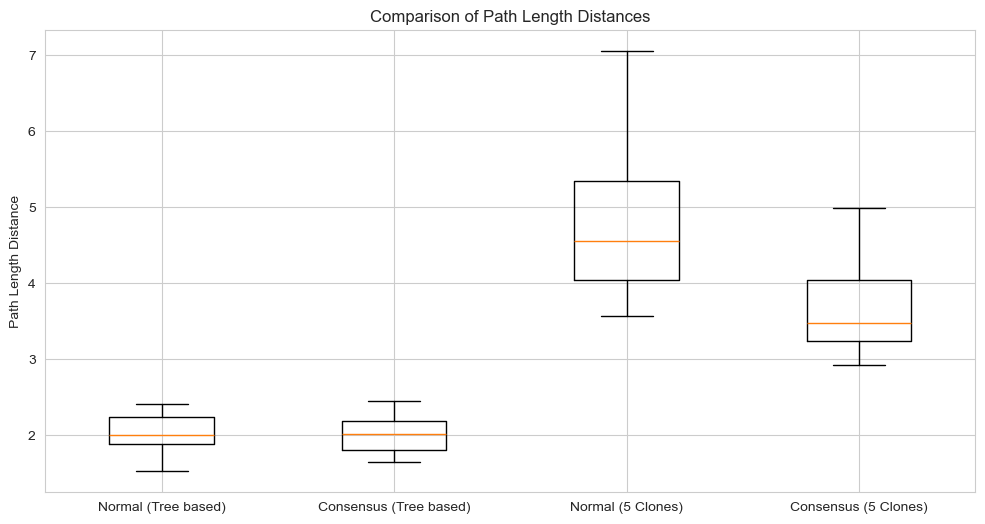

In [8]:
consensus_5 = [3.1918367346938776, 4.492244897959184, 3.449795918367347, 4.2089795918367345, 3.957551020408163, 3.3714285714285714, 3.473469387755102, 4.029387755102041, 2.9314285714285715, 3.1885714285714286, 3.3893877551020406, 3.4783673469387755, 3.533061224489796, 3.20734693877551, 4.255510204081633, 3.5183673469387755, 3.1208163265306124, 3.249795918367347, 4.08, 4.994285714285715]
consensus = [2.1053061224489795, 2.043265306122449, 1.8261224489795918, 1.7763265306122449, 1.6653061224489796, 2.446530612244898, 1.6848979591836735, 2.222857142857143, 2.32, 1.9248979591836735, 2.2351020408163267, 1.6481632653061224, 2.143673469387755, 1.876734693877551, 1.766530612244898, 2.203265306122449, 1.8253061224489795, 1.986122448979592, 2.186122448979592, 2.0644897959183672]

normal_5 = [5.496326530612245, 6.394285714285714, 4.916734693877551, 6.509387755102041, 4.204897959183674, 4.045714285714285, 4.587755102040816, 5.603265306122449, 3.566530612244898, 4.533877551020408, 4.671836734693877, 3.9151020408163264, 4.027755102040817, 3.759183673469388, 5.292244897959184, 4.450612244897959, 4.596734693877551, 4.271020408163265, 4.040816326530612, 7.053877551020408]

normal = [1.9224489795918367, 1.6081632653061224, 1.8326530612244898, 1.526530612244898, 2.2057142857142855, 2.229387755102041, 2.0742857142857143, 2.280816326530612, 2.3183673469387753, 1.969795918367347, 2.0195918367346937, 1.6873469387755102, 2.4106122448979592, 2.1975510204081634, 1.889795918367347, 2.3804081632653062, 1.9714285714285715, 2.369795918367347, 1.8873469387755102, 1.9918367346938775]

# Create a figure and axis for the plot
plt.figure(figsize=(12, 6))

# Data to plot
data = [normal, consensus, normal_5, consensus_5]

# Create boxplots
plt.boxplot(data, labels=['Normal (Tree based)', 'Consensus (Tree based)', 'Normal (5 Clones)', 'Consensus (5 Clones)'])

# Add title and labels
plt.title('Comparison of Path Length Distances')
plt.ylabel('Path Length Distance')
plt.grid(True)

# Show the plot
plt.show()

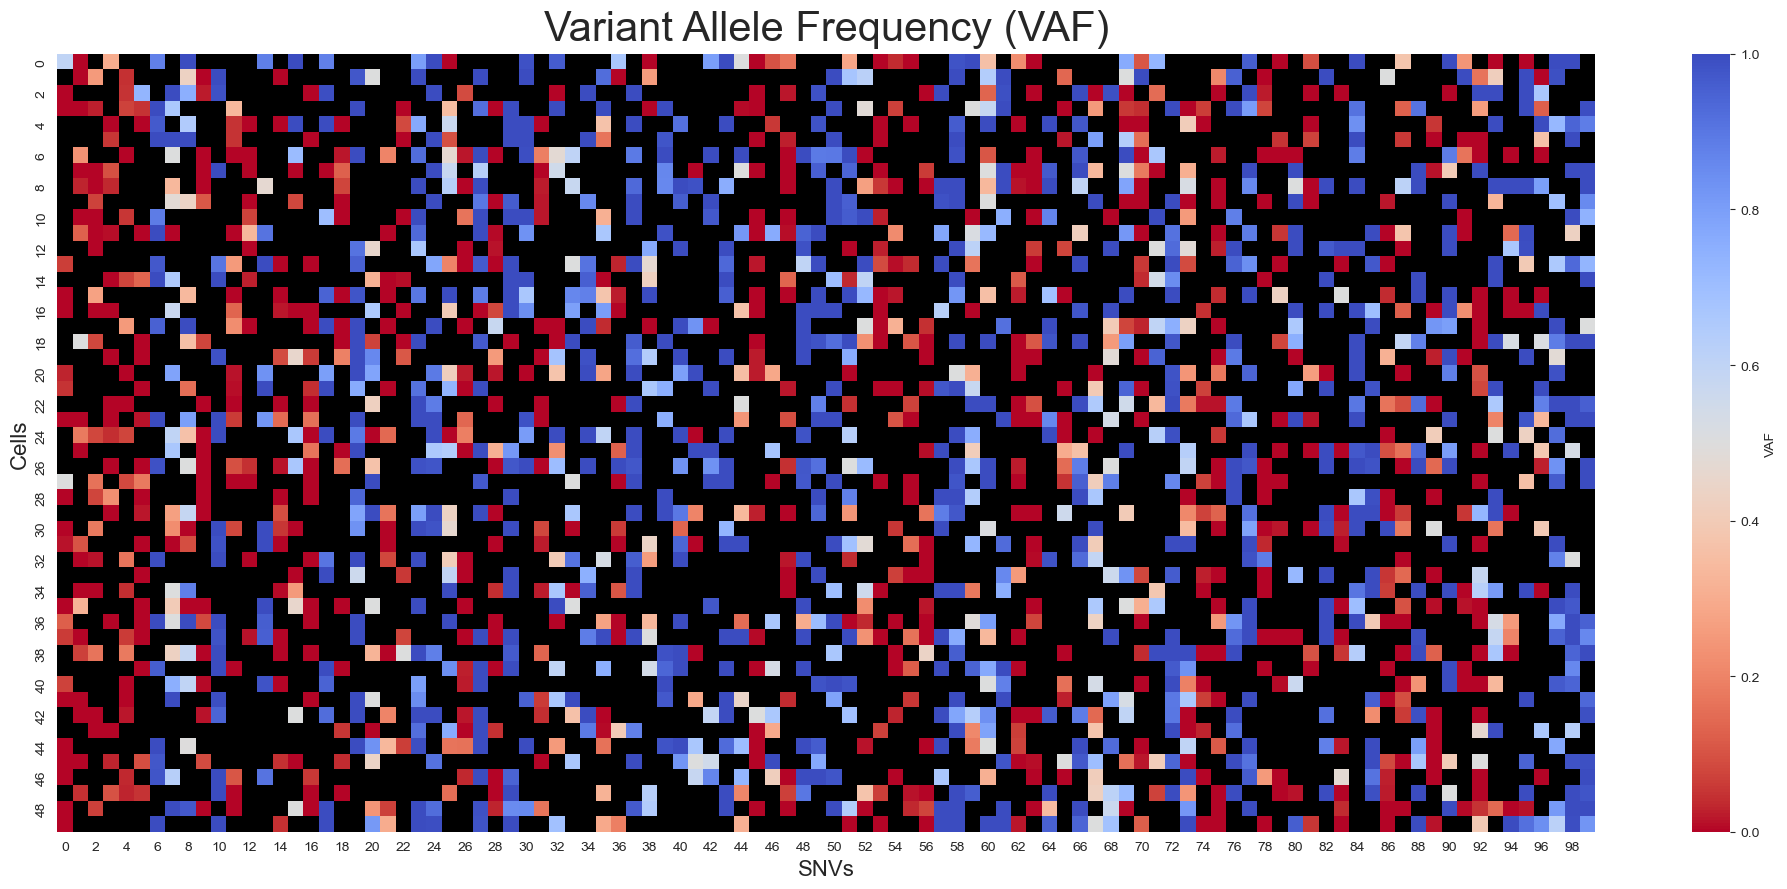

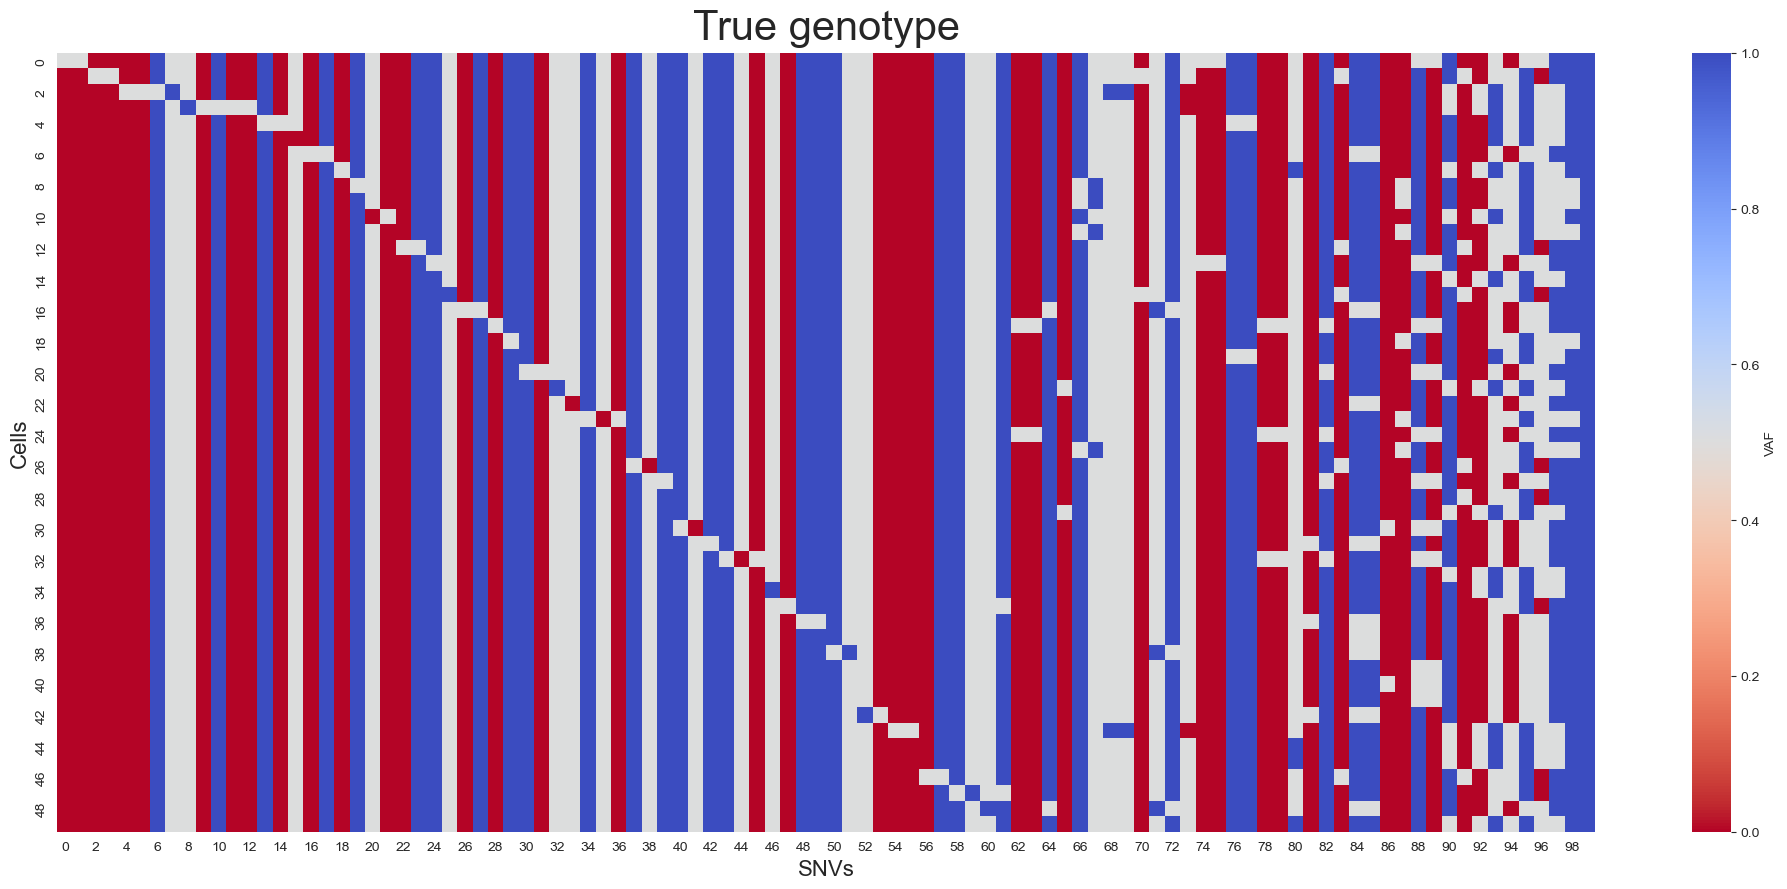

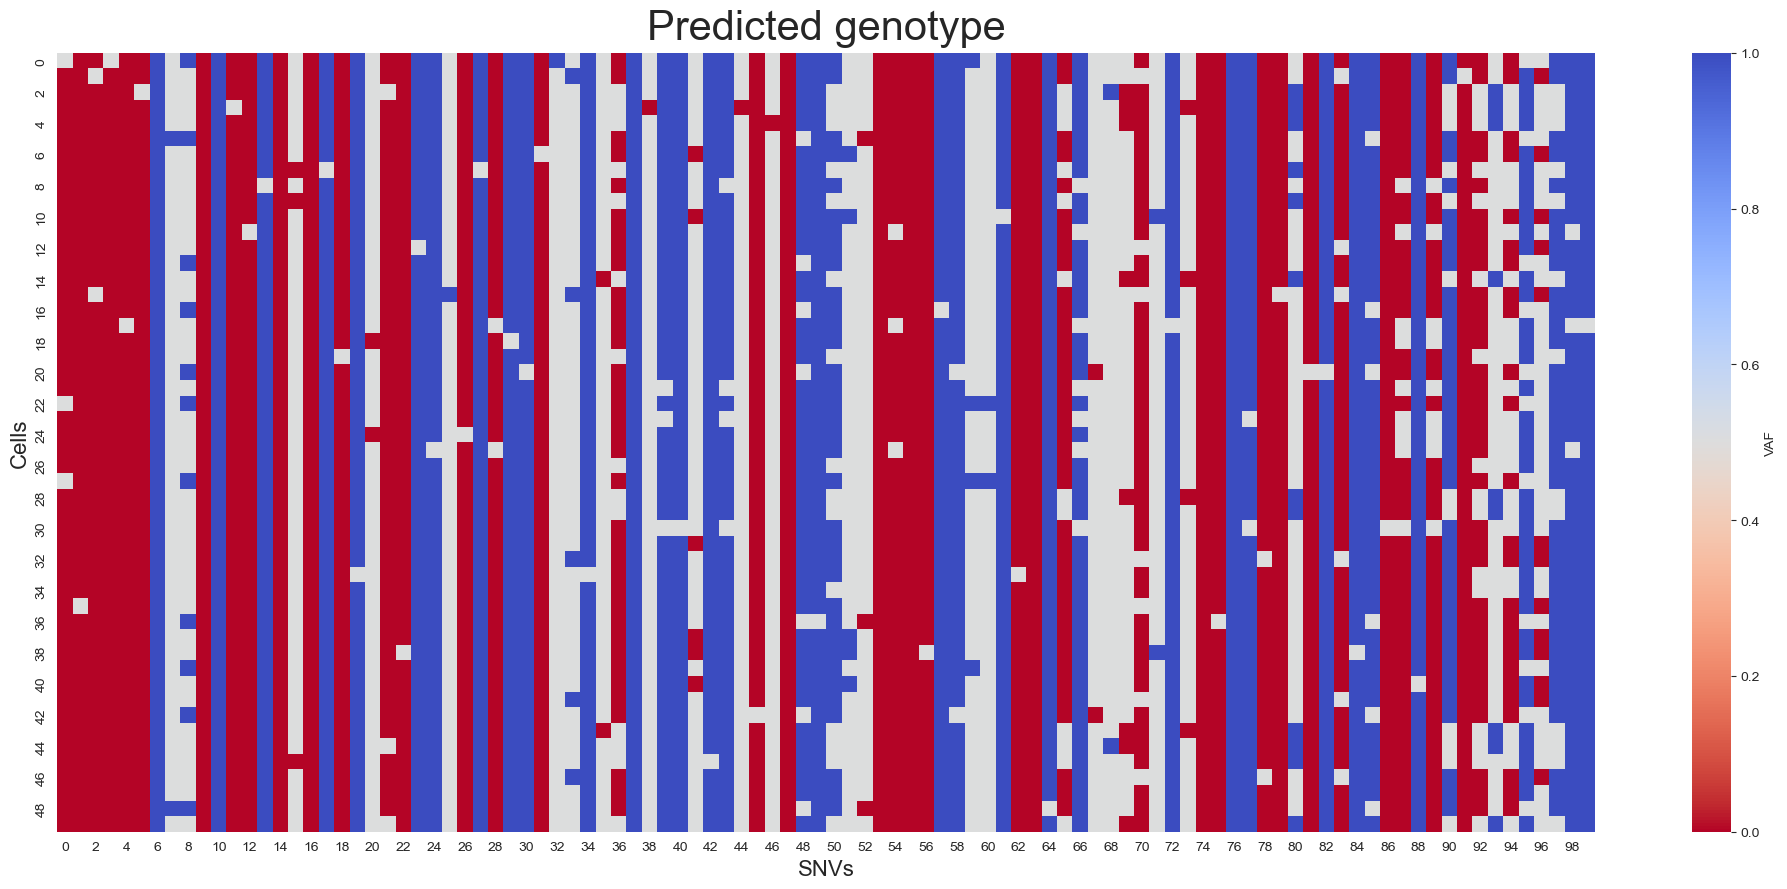

In [9]:
for t in range(1):
    alt = np.loadtxt(os.path.join(base_path, "alt", f"alt_{t}.txt"), dtype=int)
    ref = np.loadtxt(os.path.join(base_path, "ref", f"ref_{t}.txt"), dtype=int)
    mut_location = np.loadtxt(os.path.join(base_path, "mutation_location", f"mutation_location_{t}.txt"), dtype=int)
    selected = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_selected_loci", f"sciterna_selected_loci_{n_round}r{t}.txt"), dtype=int)
    genotype_gt = np.loadtxt(os.path.join(base_path, "genotype", f"genotype_{t}.txt"), dtype=str)
    sciterna_genotype = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_genotype", f"sciterna_genotype_{n_round}r{t}.txt"), dtype=str)

    mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
    vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
    genotype_gt = vectorized_map(genotype_gt)
    genotype_predicted = vectorized_map(sciterna_genotype)

    unique_sorted = np.sort(np.unique(mut_location))
    leaf_order = np.argsort([np.where(unique_sorted == x)[0][0] for x in mut_location])

    with np.errstate(divide='ignore', invalid='ignore'):
        vaf = alt / (ref + alt)

    vaf = vaf[:,leaf_order]
    genotype_gt = genotype_gt[:,leaf_order]
    genotype_predicted = genotype_predicted[:,leaf_order]

    # Define colormap: black for NaN, color gradient for valid values
    base_cmap = plt.get_cmap("coolwarm_r")  # Or 'coolwarm', 'RdYlBu'
    cmap_with_nan = base_cmap
    cmap_with_nan.set_bad(color='black')

    plt.figure(figsize=(20, 9))
    ax = sns.heatmap(
        vaf,
        cmap=cmap_with_nan,
        vmin=0,
        vmax=1,
        cbar_kws={"label": "VAF"}
    )
    plt.title(f"Variant Allele Frequency (VAF)", fontsize=30, pad=10)
    plt.xlabel("SNVs", fontsize=16)
    plt.ylabel("Cells", fontsize=16)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(20, 9))
    ax = sns.heatmap(
        genotype_gt,
        cmap=cmap_with_nan,
        vmin=0,
        vmax=1,
        cbar_kws={"label": "VAF"}
    )
    plt.title(f"True genotype", fontsize=30, pad=10)
    plt.xlabel("SNVs", fontsize=16)
    plt.ylabel("Cells", fontsize=16)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(20, 9))
    ax = sns.heatmap(
        genotype_predicted,
        cmap=cmap_with_nan,
        vmin=0,
        vmax=1,
        cbar_kws={"label": "VAF"}
    )
    plt.title(f"Predicted genotype", fontsize=30, pad=10)
    plt.xlabel("SNVs", fontsize=16)
    plt.ylabel("Cells", fontsize=16)

    plt.tight_layout()
    plt.show()

In [10]:
mut_location

array([68, 26, 15, 92, 16, 70, 95,  2, 17, 65, 32, 97, 38, 68, 94,  4, 79,
       21, 10, 16,  2, 46, 61, 46, 32, 23, 61,  1, 36, 89,  8, 47, 91,  0,
       35, 26, 62, 52, 22, 31,  1, 93,  3,  3, 98, 36, 42, 20,  5, 88, 83,
       54,  3, 83, 23, 48, 94, 30, 89,  7, 42, 12,  4, 27, 76, 74, 43, 53,
       10, 43,  6, 71,  0, 51, 34, 96, 23, 64, 71, 30, 18, 32,  2, 38, 12,
       64, 72,  3, 13, 90,  3, 70,  6, 20, 58,  2, 85, 47, 52, 58])

In [11]:
genotype_differences["SClineager"] = {}
path_len_differences["SClineager"] = {}
likelihood_differences["SClineager"] = {}
mut_count_differences["SClineager"] = {}

if use_summary_statistics == False:
    for n_c, n_m in zip(n_cells, n_mut):
        genotype_differences["SClineager"][f"{n_c}_{n_m}"] = {}
        path_len_differences["SClineager"][f"{n_c}_{n_m}"] = {}
        likelihood_differences["SClineager"][f"{n_c}_{n_m}"] = {}
        mut_count_differences["SClineager"][f"{n_c}_{n_m}"] = {}
        for clone in clones:
            differences = []
            path_len_distances = []
            likelihoods = []
            mut_count_distances = []
            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}{stratified}")
                vaf_pred_path = os.path.join(base_path, "sclineager", "sclineager_vaf", f"sclineager_vaf_{t}.txt")
                genotype_path = os.path.join(base_path, "genotype", f"genotype_{t}.txt")
                ref_path = os.path.join(base_path, "ref", f"ref_{t}.txt")
                alt_path = os.path.join(base_path, "alt", f"alt_{t}.txt")
        
                vaf_pred = np.loadtxt(vaf_pred_path, dtype=float)

                if vaf_pred.shape != (n_c, n_m):
                    print("Variants were filtered out, skipping this test")
                    continue
                gt = np.loadtxt(genotype_path, dtype=str)
                alt = np.loadtxt(alt_path)
                ref = np.loadtxt(ref_path)
                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
                sclineager_parent_vec = np.loadtxt(os.path.join(base_path, "sclineager", "sclineager_parent_vec", f"sclineager_parent_vec_{t}.txt"), dtype=int)
                
                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_gt = vectorized_map(gt)
                
                genotype_predicted = np.round(vaf_pred * 2) / 2
                difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                differences.append(difference)

                # selected = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_selected_loci", f"sciterna_selected_loci_{n_round}r{t}.txt"), dtype=int)
                # gt1, gt2 = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_inferred_mut_types",f"sciterna_inferred_mut_types_{n_round}r{t}.txt"), dtype=str)
                # llh_1, llh_2 = mf.get_llh_mat(ref[:, selected], alt[:, selected], gt1, gt2)

                ct_gt = CellTree(n_c)
                # ct_gt.fit_llh(llh_1, llh_2)
                ct_sclineager = CellTree(n_c)
                # ct_sclineager.fit_llh(llh_1, llh_2)
                #
                ct_gt.use_parent_vec(true_parent_vec)
                # ct_gt.update_all()
                #
                ct_sclineager.use_parent_vec(sclineager_parent_vec)
                # ct_sclineager.update_all()
                #
                # mut_matrix = create_mutation_matrix(sclineager_parent_vec, ct_sclineager.mut_loc, ct_sclineager)
                # genotype_matrix = create_genotype_matrix([], selected, gt1, gt2, mut_matrix, ct_sclineager.flipped)
                # genotype_matrix = vectorized_map(genotype_matrix)

                mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))
                path_len_distances.append(path_len_dist(ct_gt, ct_sclineager))
                # path_len_distances.append(mut_count_distance(genotype_gt, genotype_matrix))
                # differences.append(np.mean(np.abs(genotype_matrix - genotype_gt)))

                # likelihoods.append((ct_sclineager.joint - ct_gt.joint) / (ct_sclineager.n_cells * ct_sclineager.n_mut))

            genotype_differences["SClineager"][f"{n_c}_{n_m}"][clone] = differences
            path_len_differences["SClineager"][f"{n_c}_{n_m}"][clone] = path_len_distances
            likelihood_differences["SClineager"][f"{n_c}_{n_m}"][clone] = likelihoods
            mut_count_differences["SClineager"][f"{n_c}_{n_m}"][clone] = mut_count_distances
            print(np.mean(differences), " mean abs difference of vafs predicted")
            print(np.mean(path_len_distances), " mean path length distance")
            print(np.mean(likelihoods), " mean likelihood difference")
            print(np.mean(mut_count_distances), " mean mutation count distance")

0.069803  mean abs difference of vafs predicted
3.5531591836734697  mean path length distance
nan  mean likelihood difference
7.507493877551021  mean mutation count distance


C:\Users\Norio\anaconda3\envs\RNA\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Norio\anaconda3\envs\RNA\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [12]:
genotype_differences["DENDRO"] = {}
path_len_differences["DENDRO"] = {}
likelihood_differences["DENDRO"] = {}
mut_count_differences["DENDRO"] = {}

if use_summary_statistics == False:
    for n_c, n_m in zip(n_cells, n_mut):
        genotype_differences["DENDRO"][f"{n_c}_{n_m}"] = {}
        path_len_differences["DENDRO"][f"{n_c}_{n_m}"] = {}
        likelihood_differences["DENDRO"][f"{n_c}_{n_m}"] = {}
        mut_count_differences["DENDRO"][f"{n_c}_{n_m}"] = {}
        for clone in clones:
            differences = []
            path_len_distances = []
            likelihoods = []
            mut_count_distances = []
            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}{stratified}")
                clones_pred_path = os.path.join(base_path, "dendro", "dendro_clones", f"dendro_clones_{t}.txt")
                clones_pred = np.loadtxt(clones_pred_path, dtype=float)
                if len(clones_pred) != n_c:
                    print("Cells were filtered out, skipping this test")
                    continue

                genotype_path = os.path.join(base_path, "genotype", f"genotype_{t}.txt")
                ref_path = os.path.join(base_path, "ref", f"ref_{t}.txt")
                alt_path = os.path.join(base_path, "alt", f"alt_{t}.txt")
                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
                dendro_parent_vec = np.loadtxt(os.path.join(base_path, "dendro", "dendro_parent_vec", f"dendro_parent_vec_{t}.txt"), dtype=int)
        
                gt = np.loadtxt(genotype_path, dtype=str).T
                alt = np.loadtxt(alt_path)
                ref = np.loadtxt(ref_path)
                alt_t = alt.T
                ref_t = ref.T

                with np.errstate(invalid='ignore'):
                    vaf_observed = alt_t/(alt_t + ref_t)
                
                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_gt = vectorized_map(gt)
                
                unique_classes = np.unique(clones_pred)

                # For each unique class, replace column values with the mean of the columns of that class
                for cls in unique_classes:
                    class_indices = np.where(clones_pred == cls)[0]
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=RuntimeWarning)
                        mean_values = np.nanmean(vaf_observed[:, class_indices], axis=1)

                    # in case the mean is nan replace it with the mean genotype over all cells
                    row_nanmean = np.nanmean(vaf_observed, axis=1)
                    if np.isnan(row_nanmean).any():
                        raise ValueError("Error: The array contains NaN values.")
                    mean_values = np.where(np.isnan(mean_values), row_nanmean, mean_values)
                    if np.isnan(mean_values).any():
                        raise ValueError("Error: The array contains NaN values.")

                    vaf_observed[:, class_indices] = np.tile(mean_values[:, np.newaxis], len(class_indices))


                genotype_predicted = np.round(vaf_observed * 2) / 2
                if np.isnan(genotype_predicted).any():
                    print("Error: The array contains NaN values.")
                
                difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                differences.append(difference)

                # selected = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_selected_loci", f"sciterna_selected_loci_{n_round}r{t}.txt"), dtype=int)
                # gt1, gt2 = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_inferred_mut_types",f"sciterna_inferred_mut_types_{n_round}r{t}.txt"), dtype=str)
                # llh_1, llh_2 = mf.get_llh_mat(ref[:, selected], alt[:, selected], gt1, gt2)

                ct_gt = CellTree(n_c)
                # ct_gt.fit_llh(llh_1, llh_2)
                ct_dendro = CellTree(n_c)
                # ct_dendro.fit_llh(llh_1, llh_2)

                ct_gt.use_parent_vec(true_parent_vec)
                # ct_gt.update_all()

                ct_dendro.use_parent_vec(dendro_parent_vec)
                # ct_dendro.update_all()
                # mut_matrix = create_mutation_matrix(dendro_parent_vec, ct_dendro.mut_loc, ct_dendro)
                # genotype_matrix = create_genotype_matrix([], selected, gt1, gt2, mut_matrix, ct_dendro.flipped)
                # genotype_matrix = vectorized_map(genotype_matrix)

                path_len_distances.append(path_len_dist(ct_gt, ct_dendro))
                mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))
                # path_len_distances.append(mut_count_distance(genotype_gt, genotype_matrix.T))
                # differences.append(np.mean(np.abs(genotype_matrix.T - genotype_gt)))
                # likelihoods.append((ct_dendro.joint - ct_gt.joint) / (ct_dendro.n_cells * ct_dendro.n_mut))

                    
            genotype_differences["DENDRO"][f"{n_c}_{n_m}"][clone] = differences
            path_len_differences["DENDRO"][f"{n_c}_{n_m}"][clone] = path_len_distances
            likelihood_differences["DENDRO"][f"{n_c}_{n_m}"][clone] = likelihoods
            mut_count_differences["DENDRO"][f"{n_c}_{n_m}"][clone] = mut_count_distances
            print(np.mean(differences), " mean abs difference of vafs predicted")
            print(np.mean(path_len_distances), " mean path length distance")
            # print(np.mean(likelihoods), " mean likelihood difference")
            print(np.mean(mut_count_distances), " mean mutation count distance")

0.064726  mean abs difference of vafs predicted
3.4133959183673466  mean path length distance
4.327616161616161  mean mutation count distance


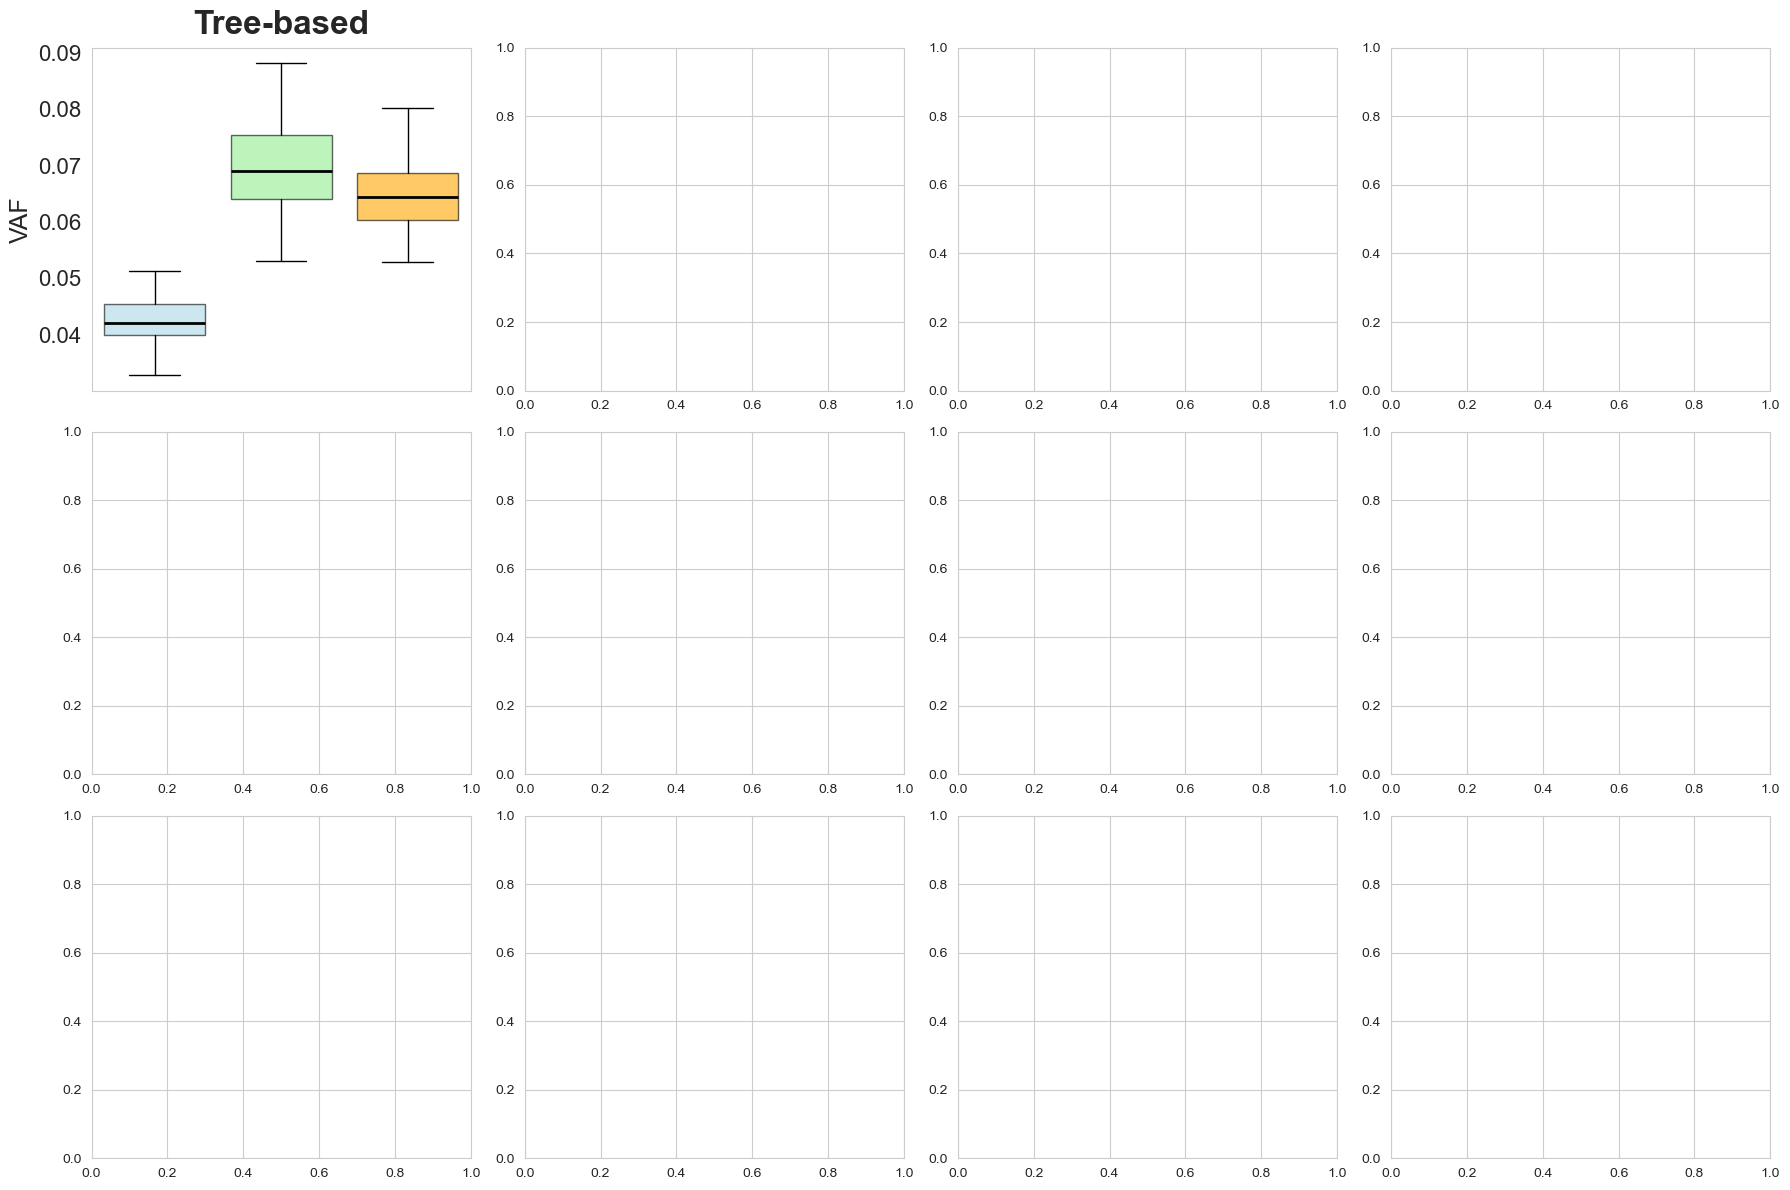

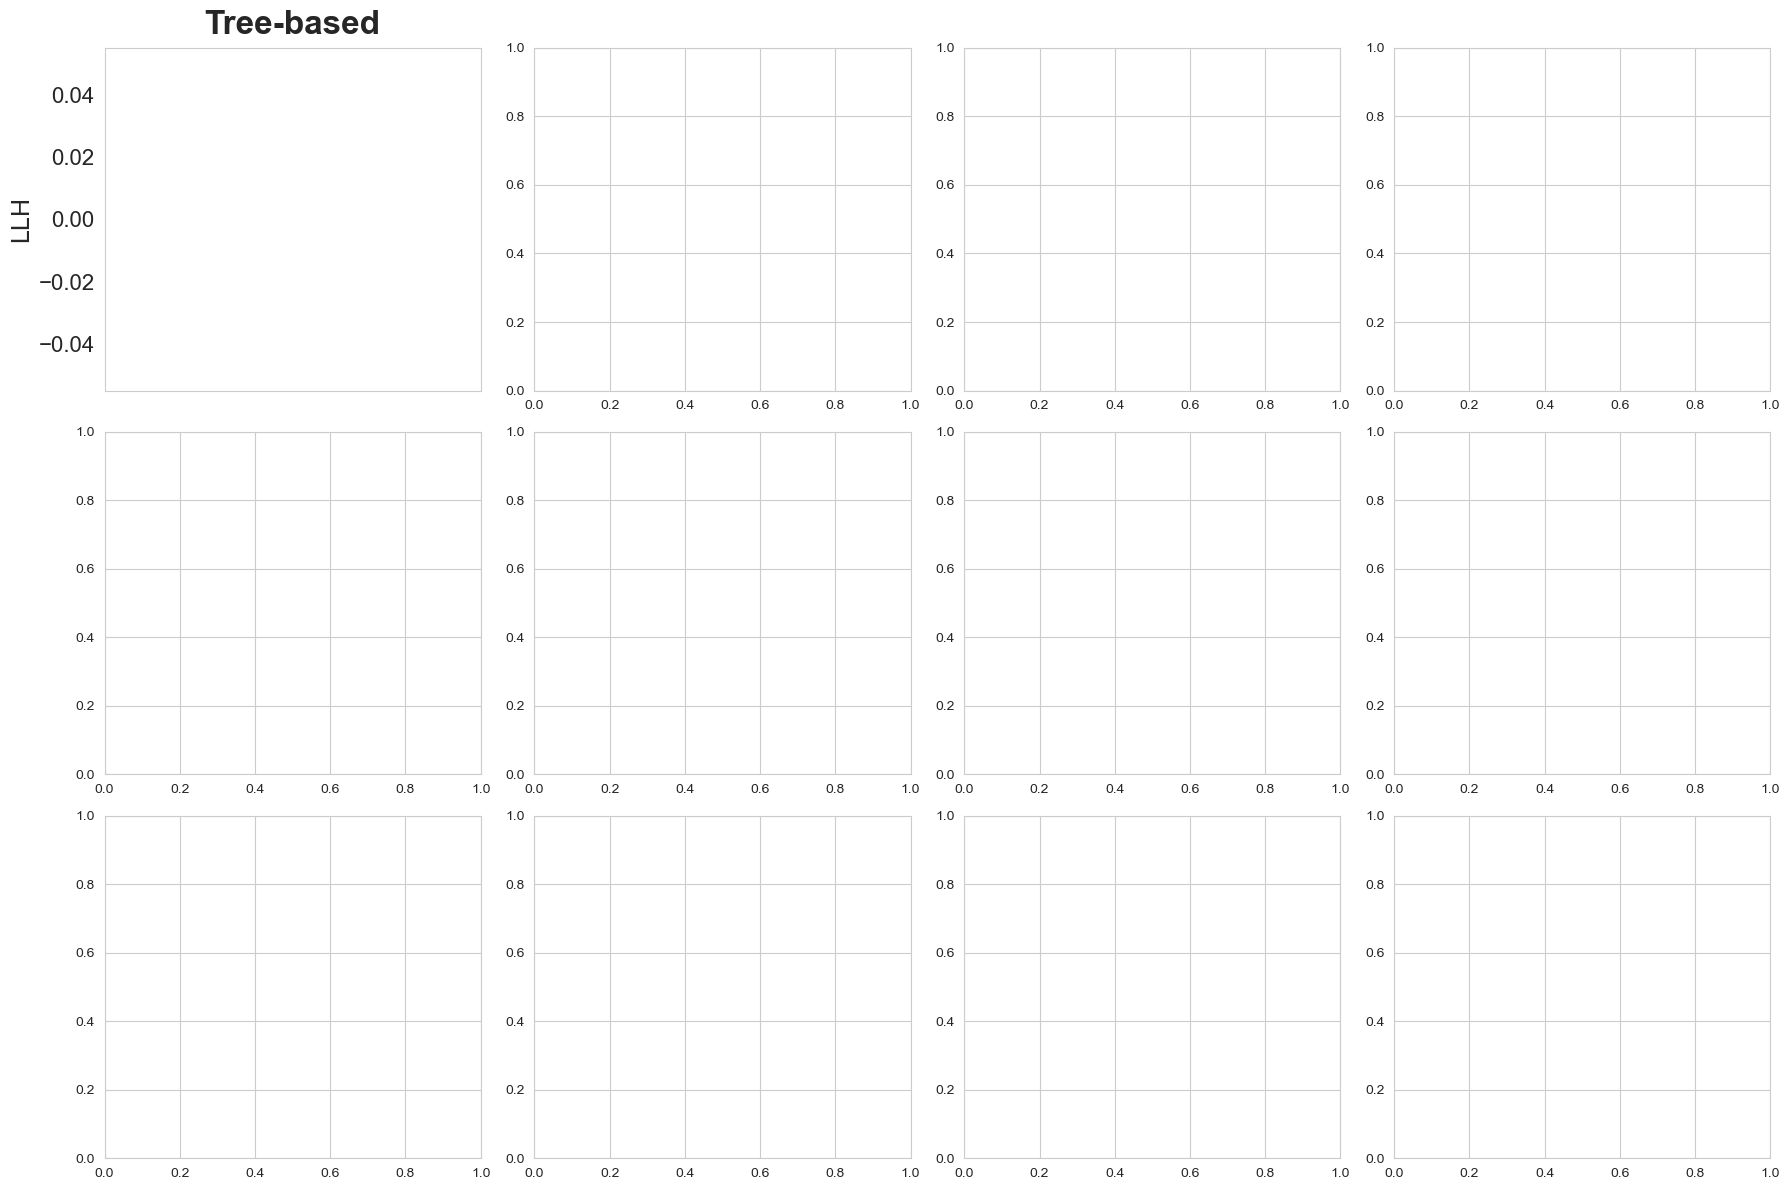

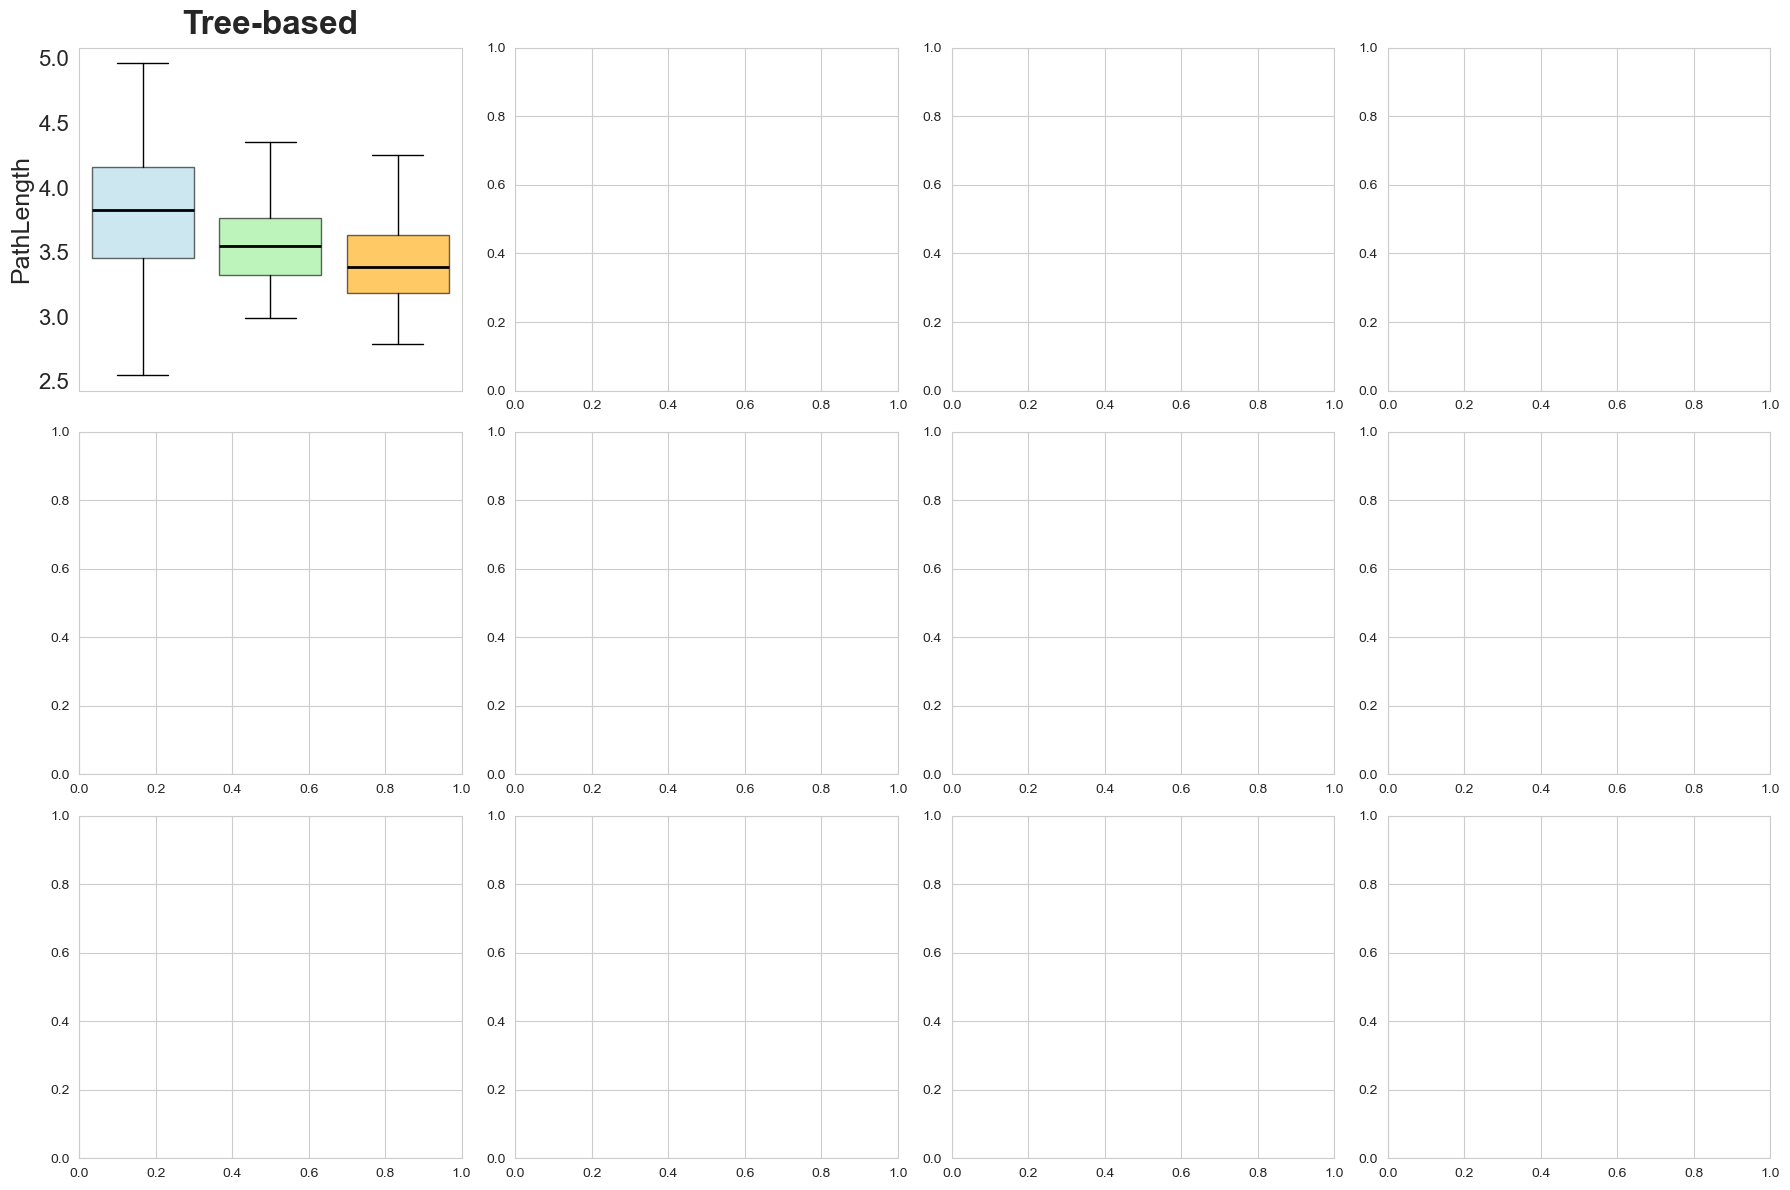

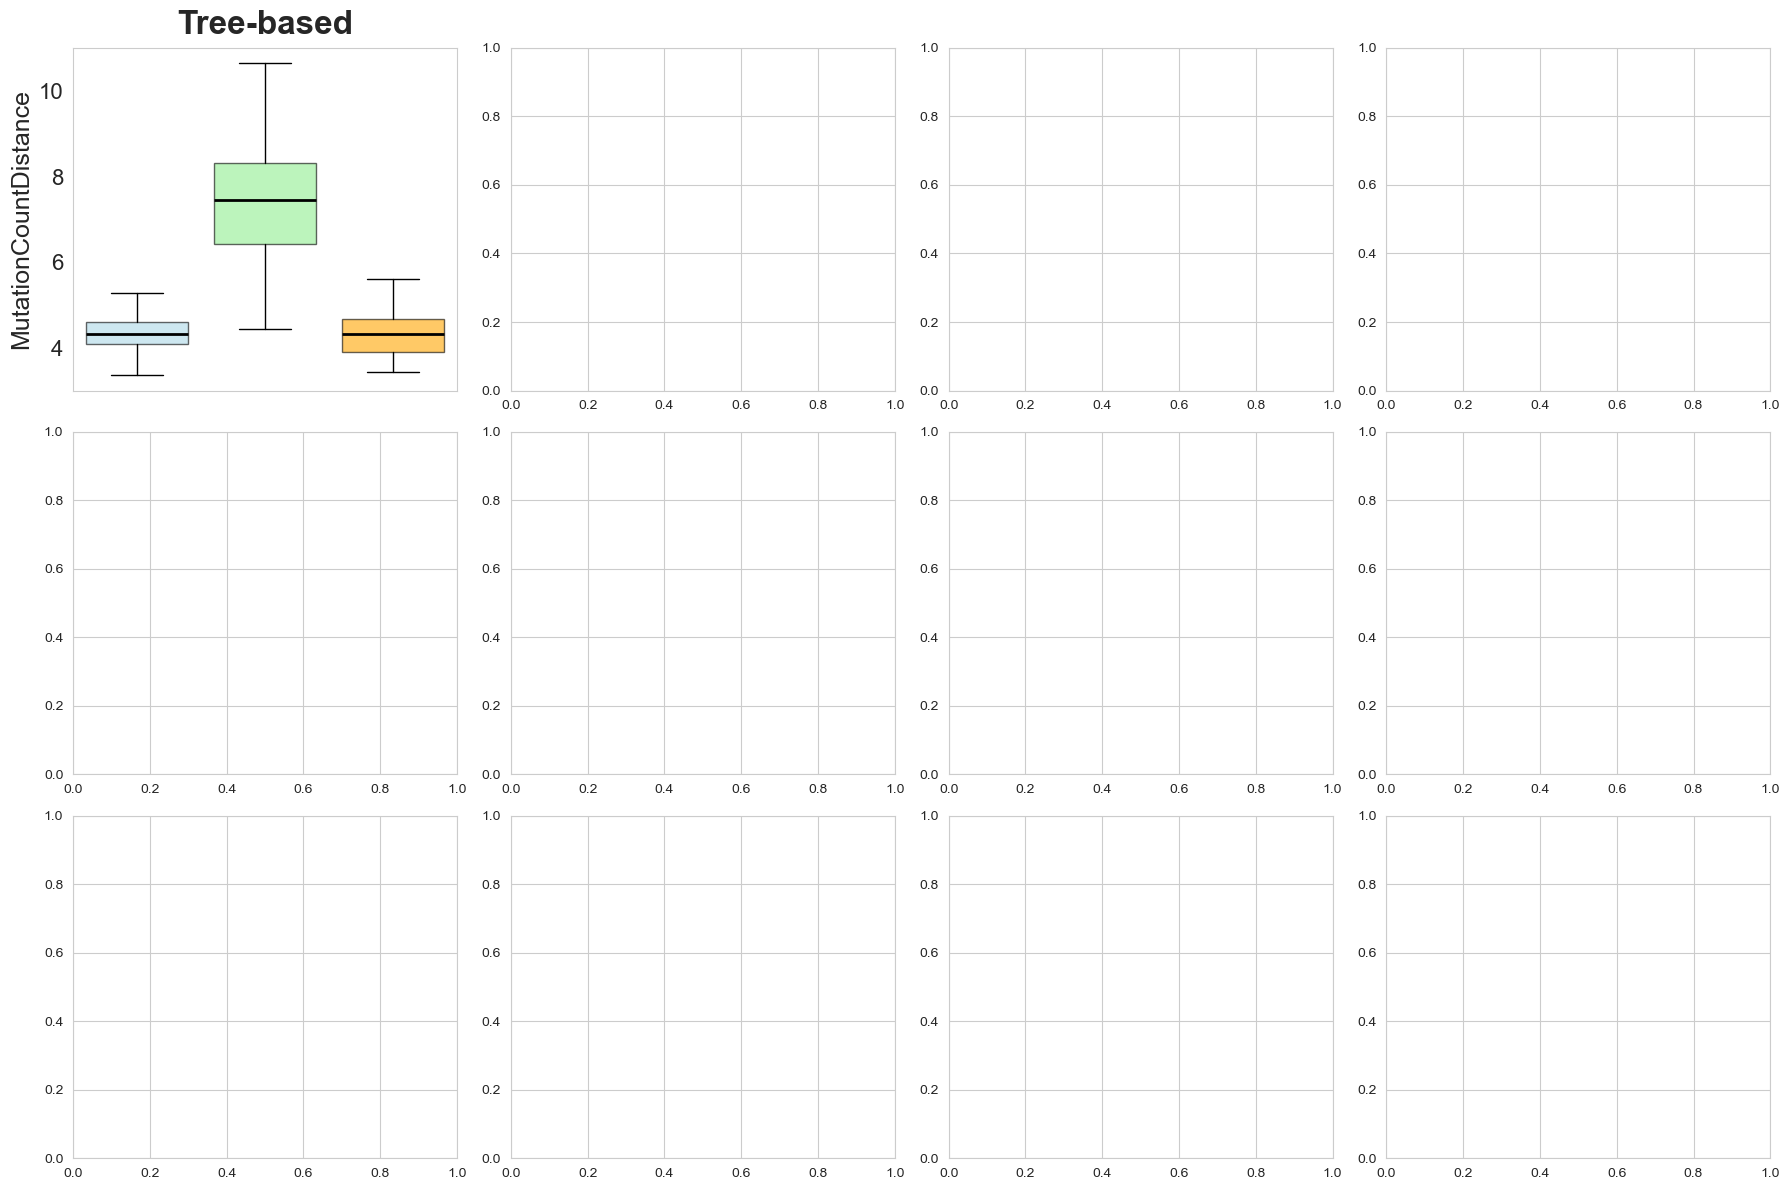

In [13]:
if use_summary_statistics:
    with open(r"../data/simulated_data/model_comparison.json") as f:
        genotype_differences = json.load(f)

def plot_results(results_data, title=""):
    models = ["SCITE-RNA", "SClineager", "DENDRO"]

    fig, axes = plt.subplots(3, 4, figsize=(18, 12), sharey=False)

    colors = ["lightblue", "lightgreen", "orange"]
    alpha_value = 0.6

    title_size = 24
    label_size = 18
    tick_size = 16
    box_width = 2.0
    boxplot_widths = 0.8

    row_y_limits = []

    for row_idx, (n_c, n_m) in enumerate(zip(n_cells, n_mut)):
        row_whiskers = []

        for col_idx, clone in enumerate(clones):
            all_samples = [results_data[model][f"{n_c}_{n_m}"][clone] for model in models]

            ax = axes[row_idx, col_idx]
            box = ax.boxplot(all_samples, patch_artist=True, widths=boxplot_widths, showfliers=False)

            for patch, color in zip(box['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(alpha_value)

            for line in box['medians']:
                line.set_linewidth(box_width)
                line.set_color("black")

            # Collect whisker data for row-level y-limit setting
            whisker_data = np.concatenate([line.get_ydata() for line in box['whiskers']])
            row_whiskers.append(whisker_data)

            if row_idx == 0:
                if clone == "":
                    ax.set_title("Tree-based", fontsize=title_size, pad=10, fontweight="bold")
                else:
                    ax.set_title(f"{clone} Clones", fontsize=title_size, pad=10, fontweight="bold")

            if row_idx == 2:
                ax.set_xticklabels(models, fontsize=tick_size)
            else:
                ax.set_xticks([])

            if col_idx == 0:
                ax.set_ylabel(f'{title}', fontsize=label_size)
            if col_idx == 3:
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(f'{n_c} Cells\n{n_m} Mutations', fontsize=label_size,
                              rotation=90, labelpad=20,
                              fontproperties=FontProperties(weight='bold'))

            ax.tick_params(axis='x', labelsize=tick_size, rotation=45)
            ax.tick_params(axis='y', labelsize=tick_size)
            ax.grid(False)

        # After processing all columns in a row, set common y-limits
        combined = np.concatenate(row_whiskers)
        ymin, ymax = combined.min(), combined.max()
        yrange = ymax - ymin
        ymin -= 0.05 * yrange
        ymax += 0.05 * yrange

        if np.isfinite(ymin):
            for col_idx in range(len(clones)):
                axes[row_idx, col_idx].set_ylim(ymin, ymax)

    plt.tight_layout()
    # plt.savefig(f"../data/results/figures/clones_{title}.png")
    plt.show()

plot_results(genotype_differences, "VAF")
plot_results(likelihood_differences, "LLH")
plot_results(path_len_differences, "PathLength")
plot_results(mut_count_differences, "MutationCountDistance")

KeyError: '50_500'

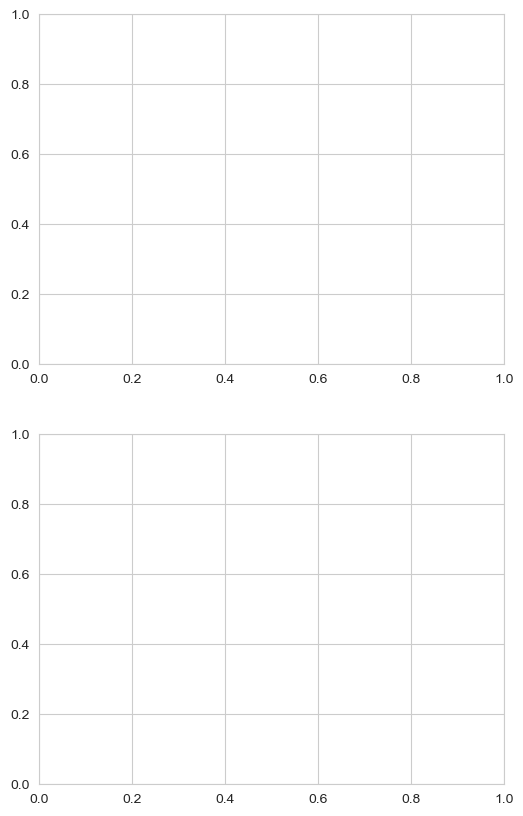

In [14]:
def plot_combined_vaf_pathlength(vaf_data, pathlen_data, clones, models=["SCITE-RNA", "SClineager", "DENDRO"]):
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.font_manager import FontProperties

    # Configuration
    n_c, n_m = 50, 500  # fixed cell and mutation counts
    rows = 2
    cols = len(clones)

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 10), sharey=False)
    if rows == 1:
        axes = np.expand_dims(axes, axis=0)

    colors = ["lightblue", "lightgreen", "orange"]
    alpha_value = 0.6

    title_size = 24
    label_size = 18
    tick_size = 16
    box_width = 2.0
    boxplot_widths = 0.8

    plot_titles = ["MAE VAF", "Path Length"]
    data_list = [vaf_data, pathlen_data]

    for row_idx, (data, plot_title) in enumerate(zip(data_list, plot_titles)):
        row_whiskers = []

        for col_idx, clone in enumerate(clones):
            sample_key = f"{n_c}_{n_m}"
            all_samples = [data[model][sample_key][clone] for model in models]

            ax = axes[row_idx, col_idx]
            box = ax.boxplot(all_samples, patch_artist=True, widths=boxplot_widths, showfliers=False)

            for patch, color in zip(box['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(alpha_value)

            for line in box['medians']:
                line.set_linewidth(box_width)
                line.set_color("black")

            whisker_data = np.concatenate([line.get_ydata() for line in box['whiskers']])
            row_whiskers.append(whisker_data)

            if row_idx == 0:
                if clone == "":
                    ax.set_title("Tree-based", fontsize=title_size, pad=10, fontweight="bold")
                else:
                    ax.set_title(f"{clone} Clones", fontsize=title_size, pad=10, fontweight="bold")

            if row_idx == 1:
                ax.set_xticklabels(models, fontsize=tick_size)
            else:
                ax.set_xticks([])

            if col_idx == 0:
                ax.set_ylabel(plot_title, fontsize=label_size)
            if col_idx == cols - 1:
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(f"{n_c} Cells\n{n_m} Mutations",
                              fontsize=label_size,
                              rotation=90, labelpad=20,
                              fontproperties=FontProperties(weight='bold'))

            ax.tick_params(axis='x', labelsize=tick_size, rotation=45)
            ax.tick_params(axis='y', labelsize=tick_size)
            ax.grid(False)

        # Apply uniform y-limits across each row
        combined = np.concatenate(row_whiskers)
        ymin, ymax = combined.min(), combined.max()
        yrange = ymax - ymin
        ymin -= 0.05 * yrange
        ymax += 0.05 * yrange

        if np.isfinite(ymin):
            for col_idx in range(cols):
                axes[row_idx, col_idx].set_ylim(ymin, ymax)

    plt.tight_layout()
    # plt.savefig("../data/results/figures/combined_VAF_PathLength.pdf")
    plt.show()

plot_combined_vaf_pathlength(genotype_differences, path_len_differences, clones)

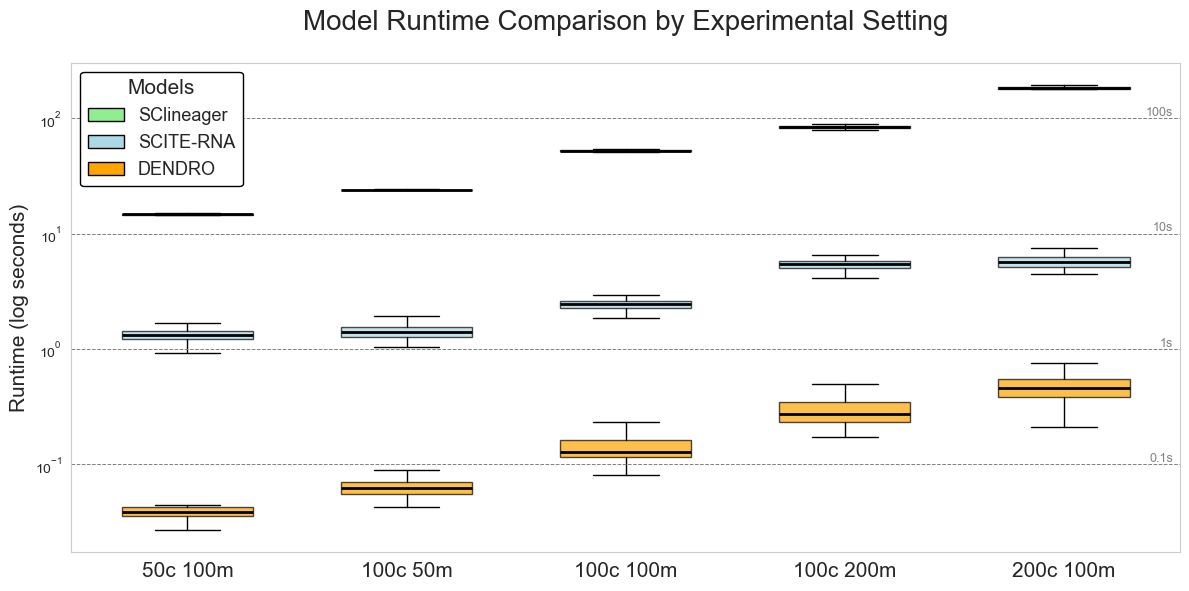

In [36]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

n_cells = [50, 100, 100, 100, 200]
n_mut = [100, 50, 100, 200, 100]
path = "../data/simulated_data/"
clone = ""
stratified = ""
models = ["SClineager", "SCITE-RNA", "DENDRO"]
colors = ["lightgreen", "lightblue", "orange"]

# Store runtimes per model per condition
runtime_data = {model: [] for model in models}
conditions = []

# Collect runtime data
for n_c, n_m in zip(n_cells, n_mut):
    condition_label = f"{n_c}c {n_m}m"
    conditions.append(condition_label)

    base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}{stratified}")
    try:
        scite_rna = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_runtimes.txt"))
        sclineager = np.loadtxt(os.path.join(base_path, "sclineager", "sclineager_runtimes.txt"))
        dendro = np.loadtxt(os.path.join(base_path, "dendro", "dendro_runtimes.txt"))
    except Exception as e:
        print(f"Error loading data for {condition_label}: {e}")
        continue

    runtime_data["SCITE-RNA"].append(scite_rna)
    runtime_data["SClineager"].append(sclineager)
    runtime_data["DENDRO"].append(dendro)

fig, ax = plt.subplots(figsize=(12, 6))

positions = []
box_data = []
group_spacing = 2
box_width = 1.2

tick_positions = []
tick_labels = []

# Organize data for plotting
for idx, condition in enumerate(conditions):
    group_positions = []
    for offset, model in enumerate(models):
        pos = idx * group_spacing # + offset
        positions.append(pos)
        group_positions.append(pos)
        box_data.append(runtime_data[model][idx])

    tick_center = np.mean(group_positions)
    tick_positions.append(tick_center)
    tick_labels.append(condition)

# Plot boxplots
box = ax.boxplot(box_data, positions=positions, widths=box_width, patch_artist=True, showfliers=False)

# Color boxes
for patch, color in zip(box["boxes"], [colors[i % 3] for i in range(len(box_data))]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Style medians
for line in box['medians']:
    line.set_color("black")
    line.set_linewidth(2.0)

# Axis formatting
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, ha='center', fontsize=15)
ax.set_ylabel("Runtime (log seconds)", fontsize=15)
ax.set_title("Model Runtime Comparison by Experimental Setting", fontsize=20, y=1.05)
ax.set_yscale("log")
ax.grid(False)

reference_lines = [0.1, 1, 10, 100]
for y in reference_lines:
    ax.axhline(y=y, color='gray', linestyle='--', linewidth=0.7)
    ax.text(len(conditions)*group_spacing - 1, y, f'{y}s', va='bottom', ha='right', fontsize=9, color='gray', zorder=1)

# Add legend
legend_patches = [Patch(facecolor=colors[i], edgecolor='black', label=models[i]) for i in range(len(models))]
ax.legend(handles=legend_patches, title="Models", loc='upper left', fontsize=13, title_fontsize=15, facecolor='white', framealpha=1.0, edgecolor='black')

plt.tight_layout()
# plt.savefig("../data/results/figures/model_runtime_comparison.pdf")
plt.show()